In [6]:
pickle_in = open('../GAMs/optimization_runs/argR_case/iter_to_best_run_info.pkl', 'rb')
iter_to_best_run_info = pickle.load(pickle_in)
pickle_in.close()

In [7]:
iter_to_best_run_info

{1: ((1, 1, 2, 1, 0, 2, 1),
  5,
  '../GAMs/optimization_runs/argR_case/iter_1/run_1168'),
 2: ((0, 2, 2, 1, 1, 1, 2),
  3.5,
  '../GAMs/optimization_runs/argR_case/iter_2/run_689'),
 3: ((1, 1, 1, 1, 1, 1, 1),
  2.4499999999999997,
  '../GAMs/optimization_runs/argR_case/iter_3/run_1093'),
 4: ((0, 1, 0, 1, 2, 2, 1),
  1.7149999999999996,
  '../GAMs/optimization_runs/argR_case/iter_4/run_295'),
 5: ((1, 2, 2, 2, 2, 2, 2),
  1.2004999999999997,
  '../GAMs/optimization_runs/argR_case/iter_5/run_1457'),
 6: ((2, 2, 2, 1, 0, 0, 2),
  0.8403499999999997,
  '../GAMs/optimization_runs/argR_case/iter_6/run_2135')}

In [11]:
dict(pd.read_csv('../GAMs/optimization_runs/argR_case/iter_6/run_2135/input_files/parameters.csv', index_col = 0)['Value'])

{'act_TF_conc_lo': 9.999999999999999e-26,
 'act_TF_conc_up': 9.999999999999999e-26,
 'act_Kd_lo': 1e-06,
 'act_Kd_up': 1.6002499999999998e-06,
 'inh_TF_conc_lo': 1.5063228974831182e-12,
 'inh_TF_conc_up': 0.0001022685769687,
 'inh_Kd_lo': 4.0273161961325956e-10,
 'inh_Kd_up': 1.6002499999999998e-06,
 'weight_act_obj1': 0.0,
 'weight_inh_obj1': 0.0541052653027954,
 'weight_act_obj2': 0.0,
 'weight_inh_obj2': 0.0,
 'weight_mRNA_match': 1.0712842529953543,
 'weight_act_corr': 0.0,
 'weight_inh_corr': 1.0226857696875e-16}

In [4]:
# imports and loadings
import os
import sys
sys.path.insert(0, '../functions/')
import create_data_for_single_gene as cdg
import interface_GAMS as iG
import parameter_optimization as po
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import numpy as np
import pickle
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
genes = ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'] #'b1101', 'b1817', 'b1818', 'b1819', 


# below are the default flags used if nothing is pre-set
# set flags by editing the "saved_flags.csv" in the ../data folder
t_half_life_deg = 300
flags = { # add additional settings that should be changed between runs here
    # general flags
    'central_gene' : 'b1819',
    'force_rerun' : True,
    'sanity_plots' : True,
    'act_iM' : 'Crp-1',
    'inh_iM' : 'DhaR/Mlc',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # picking KdRNAPCrp values
    'initial_guess_ratio' : .3, # this commonly needs to get raised and lowered to get a good value, eventually I will figure out a way to automate it if this step stays in the pipeline
    'use_target_range' : False, # if True, adds a model parameter that encourages the cActivator range to match (cInhibitor is not affected by KdRNAPCrp and can't be adjusted for here)
    'target_range' : [-1, 3],
    'base_cInhibitor_val' : 0.2, # this is the set minimum value to solve cActivator based on to set its dynamic range
    'base_cActivator_val' : 0.2, # defines the range of cInhibitor values available
    
    # cAct & cInh Grid flags
    'auto_set_max_range' : True, # if True, set the range based on the set to zero values of the KdRNAPCrp calculator
    'additional_tolerance' : 0.2, # add this %age of the maximum to the top
    'cActivator' : [-4,2], # Uses a log10 range
    'cInhibitor': [-4,2], # Uses a log10 range
    'run_greedy' : True, # skips greedy algo to save time

    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'toss', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 100, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 5, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual
}
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
TF_flags_df = pd.read_csv('../data/TF_saved_flags.csv', index_col = 0)

stable_flags = { # these do not change gene by gene
    # overall
    'only_check_KdRNAPCrp' : True, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : True, # if True, return sanity plots from this optimization
    # GAMs
    'supress_output' : False,
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'], #['b1101', 'b1817', 'b1818', 'b1819'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 1e-10,
    'act_TF_conc_up' : 1e-5,
    'act_Kd_lo' : 1e-10,
    'act_Kd_up' : 1e-6,
    'inh_TF_conc_lo' : 1e-10,
    'inh_TF_conc_up' : 1e-5,
    'inh_Kd_lo' : 1e-10,
    'inh_Kd_up' : 1e-6,
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : .1,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,
    
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    
    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
}


def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)

# TODOS
# 1 - low priority, restructure GAMs code to be able to run from saved_run_results and save off results there also (so I can reference old runs if something gets messed up)

In [5]:
# run GAMs
# below taken from 1_GAMs_parameter_optimization
best_paras = None#{'act_TF_conc_lo': 1e-11, 'act_TF_conc_up': 1e-05, 'act_Kd_lo': 1e-11, 'act_Kd_up': 1e-06, 'inh_TF_conc_lo': 1e-11, 'inh_TF_conc_up': 1e-05, 'inh_Kd_lo': 1e-11, 'inh_Kd_up': 1e-06, 'weight_act_obj1': 0.1, 'weight_inh_obj1': 0.1, 'weight_act_obj2': 0.0, 'weight_inh_obj2': 0.0, 'weight_mRNA_match': 0.055, 'weight_act_corr': 1e-17, 'weight_inh_corr': 1e-17}

if flags['force_rerun']:
    cell_constants = {}
    cell_constants.update({
        'RNAP' : stable_flags['cell_constants_RNAP'],
        'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
        'cell_volume' : stable_flags['cell_constants_cell_volume'],
        'kDeg' : stable_flags['cell_constants_kDeg'],
        'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
    })
    run_vals = [-1]
    for f in os.listdir('../GAMs/runs/'):
        if 'run_' in f: run_vals.append(int(f.split('_')[1]))
    GAMs_run_dir = '../GAMs/runs/run_'+str(max(run_vals)+1)
    os.mkdir(GAMs_run_dir)
    os.mkdir(GAMs_run_dir+'/input_files')
    os.mkdir(GAMs_run_dir+'/output_files')
    os.mkdir(GAMs_run_dir+'/input_GDX')
    os.mkdir(GAMs_run_dir+'/output_GDX')
    # 'b3357', 'b1594' for crp, mlc
    iG.run_GAMs(flags_df, TF_flags_df, stable_flags, None, 'b3237', cell_constants, GAMs_run_dir, parameter_flags = best_paras)

--- Job combined_model Start 12/06/23 15:14:48 44.1.1 27c4d1f8 LEX-LEG x86 64bit/Linux
--- Applying:
    /opt/gams/gams44.1_linux_x64_64_sfx/gmsprmun.txt
--- GAMS Parameters defined
    Input /home/chris/github/regulonML/GAMs/runs/run_79/combined_model.gms
    ScrDir /home/chris/github/regulonML/GAMs/runs/run_79/225a/
    SysDir /opt/gams/gams44.1_linux_x64_64_sfx/
Licensee: GAMS Community License for Christopher DalldorfG230829|0002AO-GEN
          University of California, San Diego, Bioengineering        CL6627
          /opt/gams/gams44.1_linux_x64_64_sfx/gamslice.txt
          Christopher Dalldorf, cdalldor@eng.ucsd.edu                      
          Community license for demonstration and instructional purposes only
Processor information: 2 socket(s), 12 core(s), and 24 thread(s) available
GAMS 44.1.1   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- combined_model.gms(43) 3 Mb
--- call csv2gdx ./input_files/composite_cAct_vals.csv id=c

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

genes = ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'] #'b1101', 'b1817', 'b1818', 'b1819', 

log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)

In [20]:
log_tpm_df.T.sort_values(by = 'b2818')[genes]

,b2818,b3959,b3958,b3359,b3957,b0273,b3172,b3960,b4254
rpoB__rpoBE672K_lb__1,3.969765,3.975679,3.551312,5.367275,6.055137,4.689172,5.849132,5.038818,1.590064
rpoB__rpoBE672K_lb__2,4.421003,3.683857,3.903651,5.565292,5.822664,4.539709,5.939982,4.909690,2.167226
rpoB__wt_lb__2,4.823058,5.450971,4.368393,4.680238,6.736347,5.470195,7.986332,6.381255,2.944941
rpoB__rpoBE546V_lb__1,5.077481,5.206693,4.611447,5.142093,6.762632,5.706832,7.275409,6.351954,2.417272
rpoB__rpoBE546V_lb__2,5.148767,5.443217,4.536098,5.283884,6.661122,5.449354,7.469806,6.282463,3.045780
...,...,...,...,...,...,...,...,...,...
ica__no3_anaero__1,10.167842,8.845766,9.113980,9.909733,8.318706,8.628413,10.531341,9.071324,7.399841
ica__no3_anaero__2,10.191005,8.895000,9.071255,9.987046,8.339778,8.687496,10.483755,8.991610,7.752101
ica__bw_delpurR_cytd__2,10.252162,9.275560,9.681007,9.020977,8.695359,10.095204,11.213601,9.633425,9.895000
ssw__glc_xyl_glc__1,10.333166,9.619314,9.885853,9.823356,8.385972,10.820839,11.312125,9.578594,10.031128


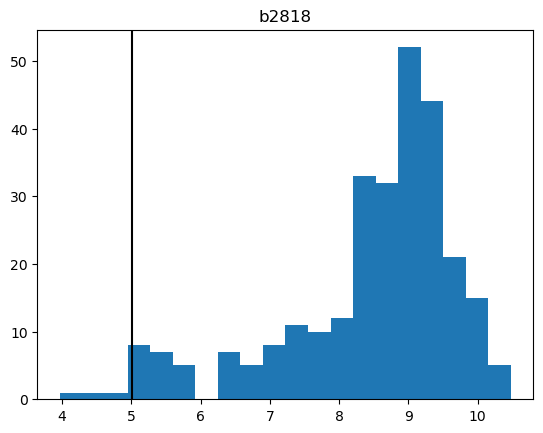

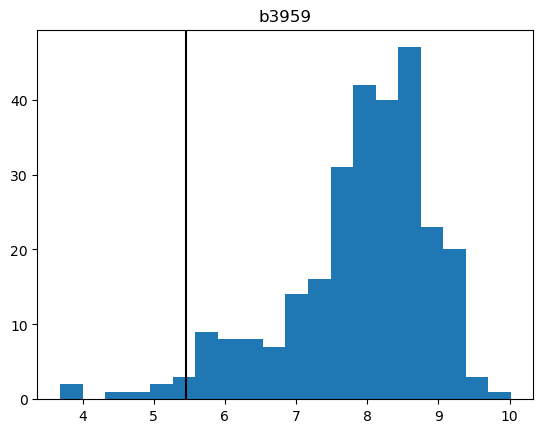

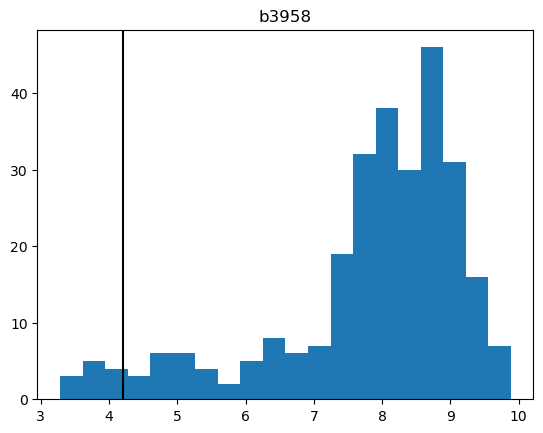

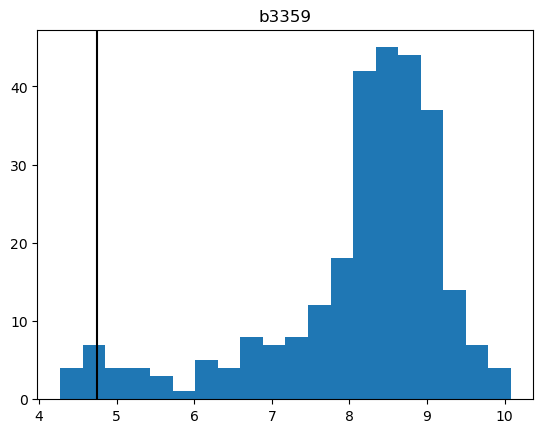

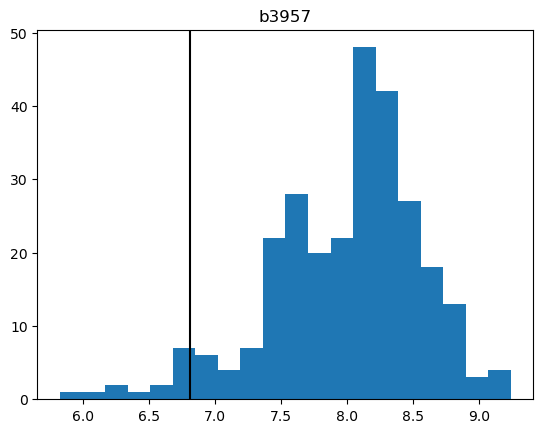

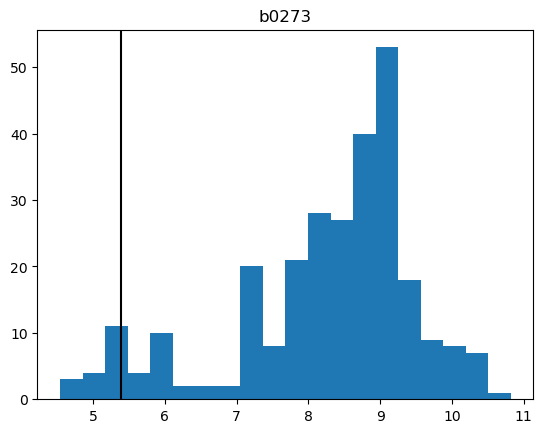

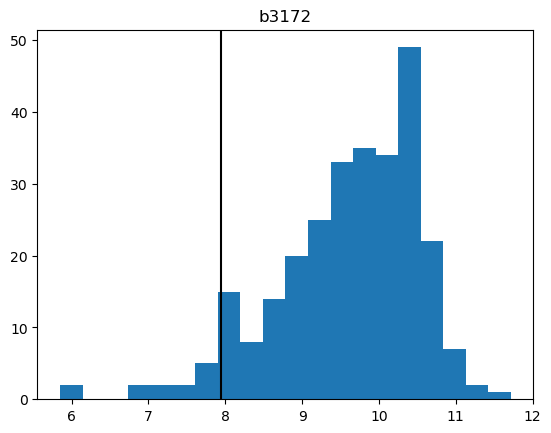

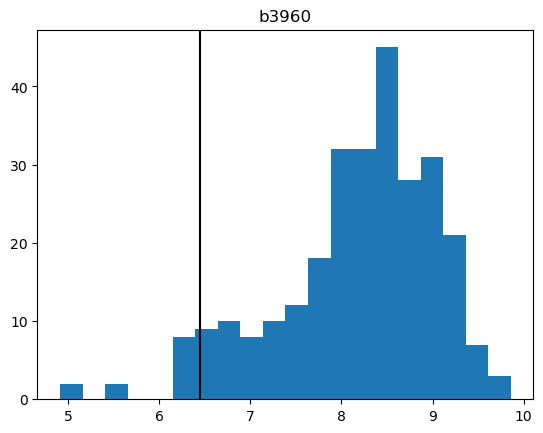

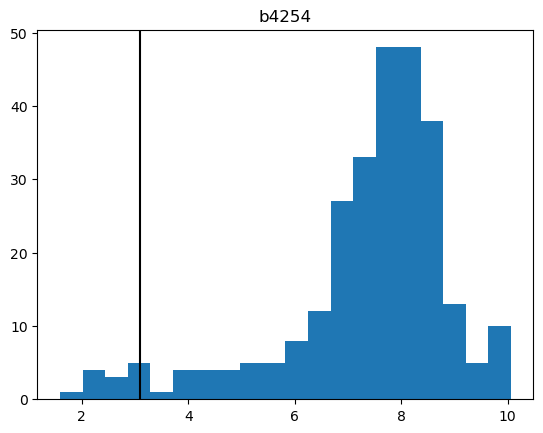

In [21]:
col = ['rpoB__wt_lb__1', 'rpoB__wt_lb__2']
for gene in genes:
    plt.figure()
    plt.hist(log_tpm_df.loc[gene], bins = 20)
    plt.axvline(x = log_tpm_df.loc[gene][col].mean(), c = 'k')
    plt.title(gene)
    plt.show()

In [24]:
log_tpm_df.loc[genes].sort_values('b2818', axis = 1)

,rpoB__rpoBE672K_lb__1,rpoB__rpoBE672K_lb__2,rpoB__wt_lb__2,rpoB__rpoBE546V_lb__1,rpoB__rpoBE546V_lb__2,ica__leu_glcr__2,oxidative__delsoxr_pq__1,ica__cytd_rib__2,rpoB__wt_lb__1,oxidative__wt_pq__1,...,omics__wt_thr__2,42c__42c_ale9__1,ica__bw_delpurR_cytd__1,ytf__delybaO__1,ytf__delyafC__2,ica__no3_anaero__1,ica__no3_anaero__2,ica__bw_delpurR_cytd__2,ssw__glc_xyl_glc__1,ytf__delyafC__1
b2818,3.969765,4.421003,4.823058,5.077481,5.148767,5.165278,5.173768,5.177665,5.209340,5.214101,...,10.042097,10.087072,10.116862,10.126465,10.134648,10.167842,10.191005,10.252162,10.333166,10.481646
b3959,3.975679,3.683857,5.450971,5.206693,5.443217,4.576435,5.725620,5.747279,5.447221,6.158100,...,8.192253,8.662756,9.363078,9.411545,9.576564,8.845766,8.895000,9.275560,9.619314,10.018993
b3958,3.551312,3.903651,4.368393,4.611447,4.536098,4.774625,4.126324,4.205685,4.038409,3.281128,...,9.884542,9.439436,9.698859,9.494716,9.518728,9.113980,9.071255,9.681007,9.885853,9.821087
b3359,5.367275,5.565292,4.680238,5.142093,5.283884,4.722924,4.271256,4.927922,4.814568,4.796608,...,8.650980,9.300279,9.300230,9.193808,9.420237,9.909733,9.987046,9.020977,9.823356,9.521362
b3957,6.055137,5.822664,6.736347,6.762632,6.661122,6.467399,7.871089,7.014625,6.881348,8.082341,...,9.123832,8.728935,8.527904,8.532730,8.739415,8.318706,8.339778,8.695359,8.385972,8.755528
b0273,4.689172,4.539709,5.470195,5.706832,5.449354,5.082892,5.190927,4.801824,5.306671,5.479159,...,8.913530,8.898565,10.096742,9.835953,9.984538,8.628413,8.687496,10.095204,10.820839,10.318640
b3172,5.849132,5.939982,7.986332,7.275409,7.469806,6.826519,7.993507,7.599229,7.895666,7.850112,...,10.339643,10.121615,11.091609,10.663640,10.693471,10.531341,10.483755,11.213601,11.312125,10.944984
b3960,5.038818,4.909690,6.381255,6.351954,6.282463,5.474631,6.605348,6.258583,6.504777,6.572199,...,8.027530,8.892632,9.604260,9.230444,9.313715,9.071324,8.991610,9.633425,9.578594,9.715525
b4254,1.590064,2.167226,2.944941,2.417272,3.045780,4.891922,2.414858,6.420952,3.235311,2.707191,...,8.135104,7.663346,9.858863,9.299559,9.509380,7.399841,7.752101,9.895000,10.031128,10.057668


In [3]:
ls ../data/precise_1.0

A.csv                     log_tpm.csv           promoters_grouping_IM.pkl
gene_presence_list.csv    M.csv                 sample_table.csv
gene_presence_matrix.csv  M_thresholds.csv
iM_table.csv              precise1_im_info.csv


In [15]:
from pymodulon.io import save_to_json, load_json_model
import pandas as pd

In [8]:
ica_data = load_json_model('../data/temp/p1k_starve_series.json')

In [13]:
ica_data.sample_table.to_csv('./delete_me.csv')

In [17]:
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/project_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

In [25]:
M_df = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0)
iM_table = pd.read_csv('../data/precise_1.0/iM_table.csv', index_col = 0)
M_df = M_df.rename(columns = {str(index) : row['name'] for index, row in iM_table.iterrows()})

In [26]:
M_df

,YieP,GlpR,YgbI,efeU-repair,ydcI-KO,BW25113,proVWX,DhaR/Mlc,ArgR,YneJ,...,RpoS,membrane,duplication-1,uncharacterized-3,ExuR/FucR,FecI,iron-related,RbsR,sgrT,insertion
b0002,0.072693,-0.006320,-0.038374,-0.010045,-0.004345,-0.005599,0.009043,-0.005072,-0.012186,-0.013543,...,-0.010152,-0.012124,-0.012027,-0.002123,-0.000036,-0.013667,-0.018883,0.004408,-0.006315,-0.001780
b0003,0.015975,-0.009969,-0.024571,-0.006775,-0.003583,0.006680,-0.010841,-0.012620,-0.003685,0.003512,...,0.004702,0.004402,0.001182,-0.004415,-0.001514,-0.005052,0.015502,0.000860,-0.022438,-0.020087
b0004,0.015319,-0.003808,-0.027018,-0.004455,-0.008418,0.003245,-0.016494,-0.013818,-0.008104,0.002144,...,0.003507,0.005342,0.003759,0.000700,0.001859,-0.002344,0.016263,0.002486,-0.016565,-0.014142
b0005,0.008229,-0.000685,-0.005215,-0.002029,-0.028069,0.014748,-0.019240,-0.002403,-0.008507,-0.019092,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
b0006,-0.004941,-0.001849,-0.002326,0.006075,0.001607,0.009678,0.001661,0.003754,-0.000152,-0.001013,...,-0.014761,0.005071,0.001496,-0.002506,-0.002819,0.005800,0.003975,-0.010976,-0.008756,0.006169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4688,-0.030311,0.008120,0.011910,0.001713,-0.005233,0.014935,0.019655,-0.025658,0.011851,-0.020593,...,-0.016448,0.009670,0.008979,0.003438,-0.019520,-0.067713,-0.021288,0.012194,0.028681,-0.025933
b4693,0.027739,0.011624,-0.013381,0.013677,0.005577,-0.008841,0.001735,0.007473,-0.007097,0.031408,...,-0.007476,-0.003357,0.001309,-0.014741,0.004931,-0.007483,-0.017265,0.000494,-0.000197,0.042749
b4696_1,0.009761,0.005718,-0.001005,-0.004127,-0.000752,0.017119,0.006490,0.001626,-0.002876,0.010560,...,-0.007016,0.001603,0.000678,0.007108,0.000750,0.004399,-0.010742,-0.004032,-0.004957,-0.003783
b4696_2,-0.001164,0.007835,0.001547,0.002629,-0.009831,0.001307,-0.009274,0.006053,-0.003772,0.010440,...,-0.003376,0.000974,0.003979,0.030489,0.007771,0.009035,-0.008468,-0.002449,0.004692,0.007504


In [19]:
log_tpm_df

,control__wt_glc__1,control__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,fur__delfur_fe2__2,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
b0002,11.006653,11.130196,11.704951,11.888217,11.064810,10.779071,9.976401,10.291135,11.229767,11.214065,...,10.271327,10.276565,11.148538,11.170578,11.676604,11.726097,11.881529,11.923237,11.496410,11.552762
b0003,10.415654,10.523138,11.423835,11.803781,10.776984,10.597810,9.596833,10.191503,10.897938,10.861157,...,10.160291,10.116861,10.314322,10.392251,10.916426,10.909277,11.023924,11.038426,10.624301,10.764195
b0004,10.594871,10.725062,10.457270,10.779162,10.394971,10.113950,8.741617,9.082231,10.185151,10.164655,...,10.475069,10.434352,10.679541,10.723953,11.143310,11.112721,11.184795,11.241845,10.953206,11.001006
b0005,6.316102,6.258499,5.422129,5.336121,6.716069,6.410864,4.626949,4.756153,6.527653,6.136168,...,5.979079,5.705586,6.306120,6.291340,5.058537,4.835550,5.448097,5.757951,5.873964,5.808618
b0006,6.915771,6.897597,6.775645,6.782605,6.761813,6.816532,6.686767,6.860036,6.862147,6.817480,...,8.371287,8.322390,8.137515,8.071837,7.354131,7.365536,7.328101,7.314761,8.057750,8.105213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4688,2.473165,2.995816,1.308909,0.000000,2.916383,3.248885,0.790543,0.741789,2.800527,2.039165,...,1.849193,2.272005,0.000000,1.283342,1.355421,1.167070,1.734880,1.007913,0.000000,1.545422
b4693,0.868914,1.426733,2.509185,2.168134,1.755932,2.136364,3.706239,3.290548,4.268691,4.252711,...,0.772861,2.004397,0.000000,0.333735,3.202295,3.001444,3.105540,3.091406,3.380939,3.171579
b4696_1,2.646501,2.545448,3.762411,3.639348,2.064534,2.014348,3.510030,3.327140,2.468705,2.431928,...,2.857578,2.874401,2.797063,2.578195,2.734153,2.718261,3.100377,3.021188,3.225358,3.401920
b4696_2,3.084724,3.148030,3.901950,3.997730,2.639106,2.200281,3.953980,3.917770,3.044666,3.115836,...,2.617006,3.515160,3.212986,3.012930,2.597279,3.731740,3.460336,3.696665,3.483282,3.818985


In [1]:
import os

In [5]:
folders = [val for val in os.listdir('../data/saved_run_results') if 'run' in val]
if len(folders) == 0:
    run_ct = 1
else:
    run_ct = max([int(val.split('_')[1]) for val in folders]) + 1
new_run_folder = 

In [3]:
ls ../data

act_inh_pkl/                precise_1k/
cAct_cInh_vals/             saved_flags.csv
GAMS_output/                saved_mRNA_ratios_MA_vals/
gene_grid_constants/        saved_ptsG_predictions.pkl
gene_to_grid_constants.pkl  saved_run_results/
pickle_dfs/                 save_for_GAMs/
precise_1.0/                validation_data_sets/


In [17]:
import dill as pickle
import pandas as pd

In [18]:
ls ../data/act_inh_pkl

231003-b0723-greedy.pkl  231003-b1101-greedy.pkl  231003-b2239-greedy.pkl
231003-b0723.pkl         231003-b1101.pkl         231003-b2239.pkl


In [25]:
pickle_in = open('../data/act_inh_pkl/231003-b2239-greedy.pkl', 'rb')
a = pickle.load(pickle_in)

In [26]:
for val in a[0]:
    print(val)

3.630780547701014
2.884031503126606
1.7868012422392947
8.31763771102671
0.02290299101575983
0.32274567015748645
8.766983113552968
4.36515832240166
3.311311214825911
1.4454397707459274
5.011872336272724
1.4454397707459274
0.004931594317965625
2.423423603095939
2.4975121157159146
2.3988329190194904
9.120108393559097
4.168693834703354
1.0471285480508996
1.9952623149688795
1.096478196143185
0.07385234756199617
8.709635899560807
1.9952623149688795
1.0471285480508996
1.318256738556407
1.096478196143185
8.571910962764187
0.00407336746012933
0.0022547594561292965
0.20602318628389196
0.0012809129386032127
8.709635899560807
9.052135781779484
2.2194078173537797
2.850924674043761
1.390342388363182
2.0892961308540396
2.290867652767773
2.129391655928126
1.6595869074375607
0.6094688623440997
0.30150810794346394
2.884031503126606
0.0792939281823341
0.23070761952640131
0.0746842968610376
0.07511780454562579
1.9054607179632472
0.21763556090210393
0.009746605341139183
0.009993357967132988
0.0089877547690

In [10]:
a[1]

[158.48931924611142,
 115.10260045756357,
 467.72430577572993,
 367.20595561981486,
 131.56826064833706,
 130.69082724521732,
 398.1071705534973,
 364.5040313138397,
 304.9597388773301,
 177.82794100389228,
 161.63941866040753,
 159.8414720813878,
 83.4414405634976,
 158.66437984592878,
 160.3061133241512,
 158.48931924611142,
 163.08844253608459,
 141.47921883779551,
 177.82794100389228,
 251.18864315095823,
 177.82794100389228,
 155.85897002509537,
 354.81338923357566,
 253.3998178395233,
 199.52623149688807,
 187.87157649207367,
 188.574778498691,
 195.286012302152,
 0.28183829312644537,
 63.095734448019364,
 141.25375446227554,
 1.0,
 255.80017843862316,
 420.6906174144198,
 179.45618895484083,
 160.76100389622357,
 158.48931924611142,
 186.8513149655894,
 138.07200998509828,
 172.508936760998,
 178.54722404619707,
 137.92873585919483,
 132.3606786017897,
 140.14789569838922,
 112.28132146803696,
 124.30716203302838,
 141.25375446227554,
 138.69386318339315,
 181.79741279213636,
 1

In [11]:
a[2]

['control__wt_glc__1',
 'control__wt_glc__2',
 'fur__wt_dpd__1',
 'fur__wt_dpd__2',
 'fur__wt_fe__1',
 'fur__wt_fe__2',
 'fur__delfur_dpd__1',
 'fur__delfur_dpd__2',
 'fur__delfur_fe2__1',
 'fur__delfur_fe2__2',
 'acid__wt_ph5__1',
 'acid__wt_ph5__2',
 'acid__delgadx_ph5__1',
 'acid__delgadx_ph5__2',
 'acid__delgadw_ph5__1',
 'acid__delgadw_ph5__2',
 'acid__delgade_ph5__1',
 'acid__delgade_ph5__2',
 'oxidative__wt_pq__1',
 'oxidative__wt_pq__2',
 'oxidative__deloxyr_pq__1',
 'oxidative__deloxyr_pq__2',
 'oxidative__delsoxr_pq__1',
 'oxidative__delsoxr_pq__2',
 'oxidative__delsoxs_pq__1',
 'oxidative__delsoxs_pq__2',
 'nac_ntrc__wt_csn__1',
 'nac_ntrc__wt_csn__2',
 'nac_ntrc__wt_cytd__1',
 'nac_ntrc__wt_cytd__2',
 'nac_ntrc__wt_gln__1',
 'nac_ntrc__wt_gln__2',
 'nac_ntrc__bw_delnac_csn__1',
 'nac_ntrc__bw_delnac_csn__2',
 'nac_ntrc__bw_delnac_cytd__1',
 'nac_ntrc__bw_delnac_cytd__2',
 'nac_ntrc__bw_delnac_gln__1',
 'nac_ntrc__bw_delnac_gln__2',
 'nac_ntrc__bw_delnac_nh4__1',
 'nac_ntrc_

In [12]:
a[3]

(0.8952992021507751, -0.9399409588017691)

In [13]:
a[4]

{'KdRNAP': 1e-05,
 'KdRNAPCrp': 3.516641004113411e-07,
 'KeqOpening': 0.4524289955987184,
 'RNAP': 1e-06}

In [14]:
a[5]

{'seed': 42,
 'n_gen': 1000,
 'n_ind': 100,
 'n_iter': 10,
 'mu': 100,
 'lambda_': 100,
 'cx_ind': 1,
 'cx_gene': 0.6,
 'mt_ind': 0,
 'mt_gene': 0.1}

In [15]:
a[6]

IndexError: list index out of range